In [1]:
using PyPlot, LinearAlgebra

# Gradient Descent / Steepest Descent

The most basic problem in optimization is the "unconstrained" continuous optimization problem:
$$
\min_{x \in \mathbb{R}^n} f(x)
$$
where $f(x)$ is called the **objective function** (or the **loss function** in machine learning).

If the function $f(x)$ is differentiable, the simplest algorithm is to **go downhill**:

* Take a sequence of "steps" $x \to x + \alpha d$ where $\alpha$ is a step size (or "learning rate" in ML) and $d = -\nabla f$ is the **steepest-descent ("downhill") direction**.

This is called a **gradient-descent** or **steepest-descent** algorithm.  For appropriate choices of $\alpha$, it converges to a **local minimum** of the function $f(x)$.  If we are lucky enough to have an objective $f(x)$  that is a [convex function](https://en.wikipedia.org/wiki/Convex_function), a local minimum is also a *global* minimum.

In this notebook, we will explore gradient descent for the simplest case of a *convex quadratic* $f(x)$ and learn about the choice of step size $\alpha$ as well as the choice of search direction $d$ — it turns out that going directly downhill is often *not* the best strategy!

## Convex quadratic optimization

A protypical optimzation problem is to minimize a convex quadratic function:
$$
f(x) = \frac{1}{2} x^T A x - b^T x
$$
where $A = A^T$ is a **symmetric positive-definite (SPD)** matrix and $b$ is some vector.  The fact that SPD makes this function (strictly) **convex**, so that $f(x)$ will have a *unique minimum* at some $x_\star$.  (This problem is an unconstrained [quadratic programming (QP)](https://en.wikipedia.org/wiki/Quadratic_programming) problem.)

It is a straightforward calculus exercise to show that
$$
\nabla f = Ax - b
$$
so that our minimum (when $\nabla f = 0$) satisfies $\boxed{Ax_\star = b}$: minimizing $f$ is **equivalent to solving a linear-algebra equation**!

The "downhill" direction $-\nabla f = b - Ax$ is sometimes called the **residual** $r$: it is a measure of the "error", how far we are from the solution.

So, why not just solve this by a method like Gaussian elimination?  Two answers:

* For some problems, $A$ is so huge that direct methods like Gaussian elimination are impractical.  However, if the matrix $A$ has some structure that allows us to multiply $Ax$ quickly (e.g. $A$ is [sparse](https://en.wikipedia.org/wiki/Sparse_matrix): mostly zero), then we can still employ **iterative algorithms** like gradient descent that *approach* the solution $x_\star$ in a sequence of steps that only require cheap matrix–vector and vector–vector operations.
* Most optimization problems are *not* quadratic (or convex), but they are *approximately* convex quadratic near a local minimum (if they are twice differentiable).  Understanding how gradient descent works on a quadratic function will therefore help us to better understand how it behaves on more general functions for which we *don't* have a simple formula for their optimum.

## Choosing the stepsize α: Exact line minimization

Once we have a "downhill" direction $d$ (e.g. $d = -\nabla f$ for steepest descent), a basic question is: **how far do we step** along that direction to get a new point $x + \alpha d$, before choosing a new "downhill" direction?

One possible answer is to *minimize* $f(x + \alpha d)$ over $\alpha$ to find the "optimal" step size $\alpha_\star$.  This is an easier problem than minimizing $f(x)$ since it is only over one parameter $\alpha$, and this strategy is called **exact line minimization**.

The gradient at the "line minimum" $\alpha$ has a useful property: it must be *perpendicular* to $d$:
$$
\left. \nabla f \right|_{x + \alpha_\star d} \perp d
$$
since otherwise you could move further downhill by changing $\alpha$.

In the quadratic case, this makes finding $\alpha_\star$ especially easy:
$$
d^T \left. \nabla f \right|_{x + \alpha_\star d} = d^T (A (x + \alpha_\star d) - b) = \alpha_\star d^T A d + d^T (Ax - b)
$$
hence
$$
\alpha_\star = \frac{d^T (b - Ax)}{d^T A d} = \boxed{\frac{- d^T \left. \nabla f \right|_{x}}{d^T A d}} .
$$
This has two useful properties:
1. Since $A$ is SPD, $d^T A d > 0$.  We are never dividing by zero.
2. if $d$ is a "downhill" direction, then $- d^T \left. \nabla f \right|_{x}$ must be *positive*, so $\alpha_\star$ is a positive step.  In the case of steepest descent where $d = -\nabla f$, then the numerator is $\|d\|^2 = \|\nabla f\|^2$.   (One can also show that $1/\lambda_\max \le \alpha_\star \le 1/\lambda_\min$ in this case, in terms of the maximum and minimum eigenvalues of $A$.)

Here is a Julia implementation of steepest-descent ($d = -\nabla f$) with exact line search ($\alpha = \alpha_\star = \| d \|^2 / d^T A d$).  Note that on each step, we only need to multiply $A$ by one or two vectors!

In [2]:
function SD(A, b, x=zero(b); tol=1e-8, maxiters=1000, α_fixed=false)
    bnorm = norm(b)
    r = b - A*x # initial residual = -∇f
    rnorm = [norm(r)] # return the array of residual norms
    Ad = zero(r) # allocate space for Ad
    for i = 1:maxiters
        d = r # use the steepest-descent direction
        mul!(Ad, A, d) # store matvec A*r in-place in Ar
        if α_fixed === false
            α = dot(d, r) / dot(d, Ad)
        else
            α = α_fixed # fixed step size, for below
        end
        x .= x .+ α .* d  # in Julia, this "fuses" into a single in-place update
        r .= r .- α .* Ad # update the residual (without computing A*x again)
        push!(rnorm, norm(r))
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

SD (generic function with 2 methods)

### 100×100 example:

Now, let's try it out on a random $100 \times 100$ SPD matrix $A$ and a random $b$.

On each step, we'll compute the "residual" $r = b - Ax = -\nabla f$, and we'll plot the error $\| r \|$ as a function of the iteration.    Our "initial guess" $x$ will simply be the $\vec{0}$ vector.

In [3]:
A = randn(100,100); A = A'*A # a random SPD matrix
b = randn(100)
x, rnorm = SD(A, b, maxiters=100000)
length(rnorm), rnorm[end]/norm(b)

(100001, 2.1898661935779876e-7)

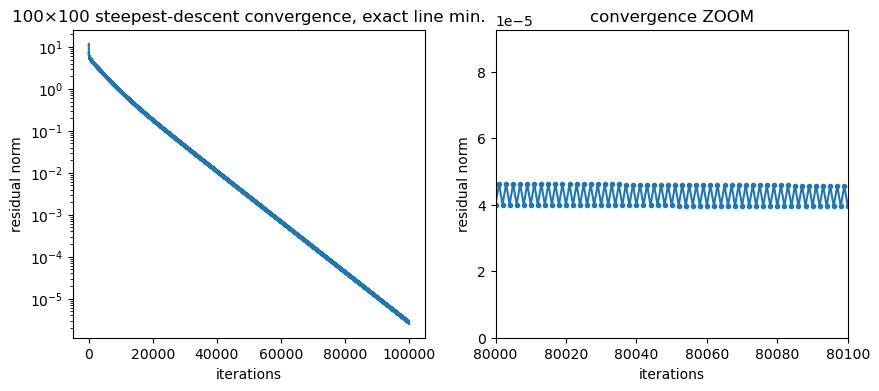

(0.0, 9.264876845621783e-5)

In [19]:
figure(figsize=(10,4))
    
subplot(1,2,1)
semilogy(rnorm)
title("100×100 steepest-descent convergence, exact line min.")
ylabel("residual norm")
xlabel("iterations")

subplot(1,2,2)
plot(rnorm, ".-")
title("convergence ZOOM")
ylabel("residual norm")
xlabel("iterations")
xlim(80000, 80100)
ylim(0, 2*maximum(rnorm[80000:80100]))

It's converging, but **pretty darn slowly** — after $10^5$ iterations, we've only reduced the residual by 1000x, and the relative error
$$
\frac{\| x - x_\star \|}{\| x_\star \|}
$$
is still pretty large:

In [5]:
x_star = A \ b # exact solution
norm(x - x_star) / norm(x_star)

6.650888617809801e-7

If we zoom in on the iterations, we see that the **residual is oscillating** so that the overall decrease is very slow!

This is a typical phenomenon with naive gradient descent, unfortunately.

To see what's going on, let's try a $2\times2$ matrix where we can easily visualize the progress.

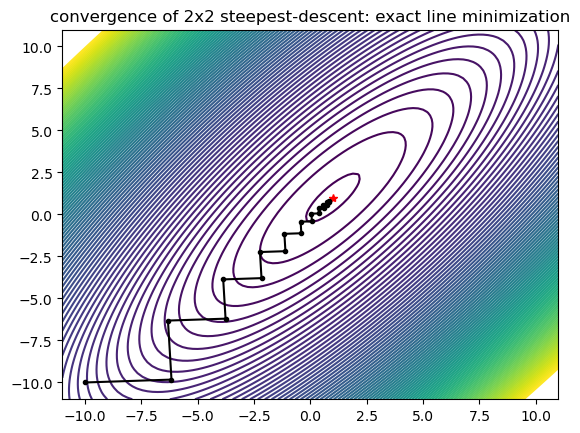

PyObject Text(0.5, 1.0, 'convergence of 2x2 steepest-descent: exact line minimization')

In [6]:
θ = 0.9 # chosen to make a nice-looking plot
Q = [cos(θ) sin(θ); -sin(θ) cos(θ)] # 2x2 rotation by θ
A₂ = Q * diagm([10,1]) * Q' # a 2x2 matrix with eigenvalues 10,1
b₂ = A₂ * [1,1] # right-hand side for solution (1,1)
x1 = range(-11,11,length=100)
contour(x1', x1, [dot([x1,x2], A₂*[x1,x2]) - 2*(x1*b₂[1]+x2*b₂[2]) for x1 in x1, x2 in x1], levels=range(1,2000,length=100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:20
    x₂, = SD(A₂, b₂, [-10.,-10.], maxiters=i)
    push!(x1s, x₂[1])
    push!(x2s, x₂[2])
end
plot(x2s, x1s, "k.-")

title("convergence of 2x2 steepest-descent: exact line minimization")

The solution "zig-zags" down the long, narrow valley defined by the quadratic function `f`.  This is a common problem of steepest-descent algorithms: they tend to go towards the center of valleys (down the "steep" direction), rather than *along* the valleys towards the solution.

To fix this problem, basically we need to implement some kind of "memory": it has to "remember" that it just "zigged" in order to avoid "zagging" back where it came from.   We'll do this below.

## Choosing the stepsize α: A fixed "learning rate"

Before we get fancier with the search direction, let's get *more primitive* with the step size α.  What happens if we simply **choose α to be a *constant*** (called the *learning rate* in ML).  What constant should we pick?  Does it matter?

For arbitrary non-quadratic functions, exact line minimization is often impractical.  People still do *approximate* line minimization (called "inexact line search", often subject to [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions)).   More generally, there are many algorithms that *adaptively* adjust the stepsize α as the optimization progresses.   But choosing a *fixed* stepsize *a priori* remains surprisingly popular, especially in machine learning where the optimization problems are typically noisy ("stochastic" optimization).   And in the quadratic case we can perform a detailed analysis.

### Quadratic optimization with a fixed step size

If $\alpha$ is a constant, and $d = -\nabla f = b - Ax$ is our steepest-descent diretion, then on each step we are setting
$$
x \longrightarrow x + \alpha d = x + \alpha (b - Ax)
$$
In this case, it is revealing to consider what happens to the *residual* (error) $r = b - Ax$:
$$
r = b - Ax \longrightarrow b - A(x + \alpha r) = r - \alpha A r = \boxed{(I - \alpha A) r}
$$
That is, on every step we are **multiplying the residual** by $\boxed{I - \alpha A}$.  On the $n$-th step, we have multiplied by $(I - \alpha A)^n$.

But this is a **matrix powers** problem (a "discrete dynamical system"), and we know how to analyze it: it will converge (to zero error!) if the eigenvalues of $I - \alpha A$ have **magnitude < 1**.   But if the eigenvalues of $A$ are $\lambda_k$ ($> 0$ since $A$ is SPD), then $I - \alpha A$ has eigenvalues $1 - \alpha \lambda_k$.  So:

* For steepest descent to converge with a fixed stepsize, we must choose $\alpha$ so that $|1 - \alpha \lambda_k| < 1$ for all eigenvalues $\lambda_k$ of $A$.  It immediately follows that we must have $\boxed{0 < \alpha < 2/\lambda_\max}$.

Moreover, the convergence *rate* will be determined by the *biggest-magnitude* eigenvalue of $I - \alpha A$, i.e the *biggest* $|1 - \alpha \lambda_k|$.  How should we choose $\alpha$ to make this as small as possible?  It's instructive to plot $|1 - \alpha \lambda_k|$ versus $\alpha$ for $\lambda_\max$ and $\lambda_\min$, below:

From this plot, we can see that the best *fixed* $\alpha$ is when $1 - \alpha \lambda_\min = \alpha \lambda_\max - 1$, which gives $\boxed{\alpha = 2 / (\lambda_\max + \lambda_\min)}$.

For this optimal $\alpha$, the biggest-magnitude eigenvalue has magnitude
$$
\alpha \lambda_\max - 1 = \frac{2 \lambda_\max}{\lambda_\max + \lambda_\min} - 1 = \frac{\lambda_\max - \lambda_\min}{\lambda_\max + \lambda_\min} = \boxed{\frac{\kappa - 1}{\kappa + 1}}
$$
where $\kappa = \lambda_\max / \lambda_\min = \sigma_\max / \sigma_\min$ is the [condition number](https://en.wikipedia.org/wiki/Condition_number) of the matrix $A$.  (Since $A$ is SPD, $\sigma = \lambda$.) The upshot is that **if A is ill-conditioned (κ >> 1), steepest descent converges slowly** because we have a dominant eigenvalue only slightly less than 1.  (Indeed, it turns out that the number of steps is roughly proportional to $1/\kappa$.)

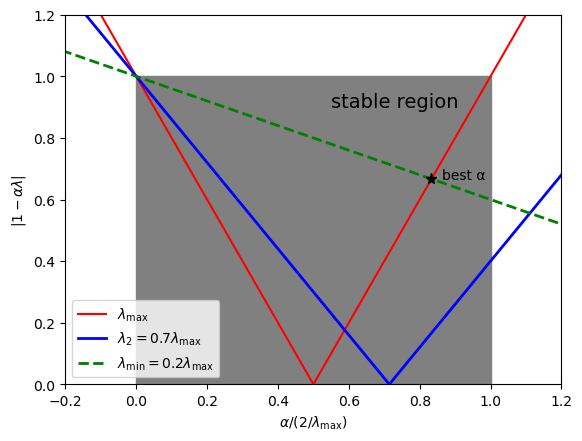

PyObject Text(0.55, 0.9, 'stable region')

In [7]:
λmax = 1
λ2 = 0.7
λmin = 0.2
α = range(-0.5/λmax, 2.5/λmax, length=1000)

plot(α / (2/λmax), abs.(1 .- α .* λmax), "r-")
plot(α / (2/λmax), abs.(1 .- α .* λ2), "b-", linewidth=2)
plot(α / (2/λmax), abs.(1 .- α .* λmin), "g--", linewidth=2)
xlabel(L"\alpha / (2/\lambda_\max)")
ylabel(L"|1 - \alpha \lambda|")
legend([L"\lambda_\max", L"\lambda_2 = 0.7\lambda_\max", L"\lambda_\min = 0.2\lambda_\max"])

α0 = 2 / (λmax + λmin)
plot(α0 / (2/λmax), abs.(1 .- α0 .* λmax), "k*", markersize=8)
text(α0 / (2/λmax) + 0.03, abs.(1 .- α0 .* λmax), "best α")

fill([0, 1, 1, 0], [0, 0, 1,1], color="gray")
ylim(0,1.2)
xlim(-0.2, 1.2)
text(0.55, 0.9, "stable region", fontsize=14)

### Numerical results for fixed step size

Now, let's try it out on our problems above.  First, let's do the 100×100 example with the optimal fixed step size:

In [8]:
λ = eigvals(A)
λmin = λ[1]
λmax = λ[end]
αopt = 2 / (λmax + λmin)

x_fixed, rnorm_fixed = SD(A, b, maxiters=100000, α_fixed=αopt)
length(rnorm_fixed), rnorm_fixed[end]/norm(b)

(100001, 2.2419170480036973e-7)

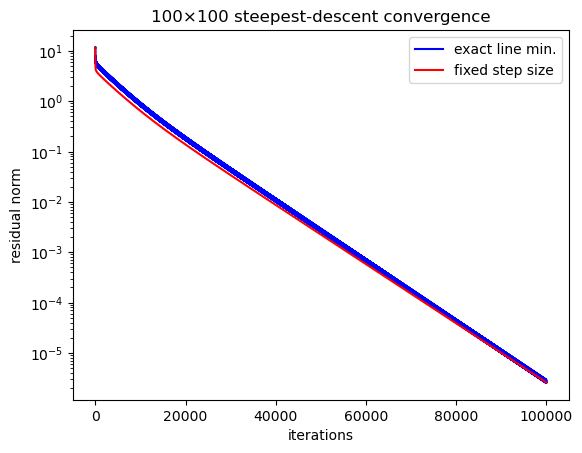

PyObject <matplotlib.legend.Legend object at 0x7fc6b5565810>

In [18]:
semilogy(rnorm, "b-")
semilogy(rnorm_fixed, "r-")
title("100×100 steepest-descent convergence")
ylabel("residual norm")
xlabel("iterations")
legend(["exact line min.", "fixed step size"])

The *optimal* fixed step size $\alpha = 2/(\lambda_\max + \lambda_\min)$ is very comparable in convergence to exact line minimization.  The difficulty is that in practice you rarely have enough information to choose the best $\alpha$ precisely.

In practice, $\alpha$ is a **hyper-parameter** of the optimization that people often **tune by hand** for a given problem (ugh), unless you use a more sophisticated optimization algorithm that chooses it adaptively.

Let's try it on our 2x2 example, with eigenvalues 10 and 1, so that we must have $0 < \alpha < 0.2$ and the optimal fixed $\alpha$ is $2/(10+1) \approx 0.1818$:

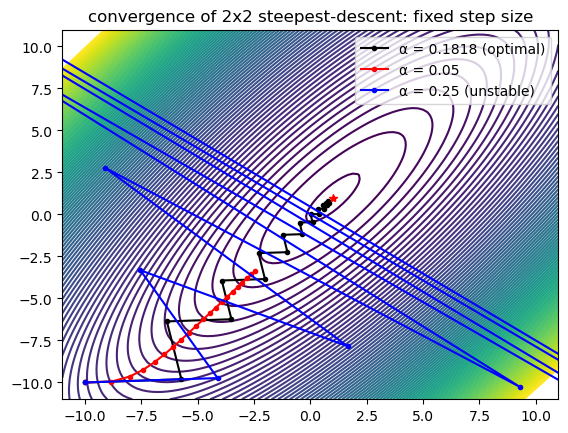

PyObject Text(0.5, 1.0, 'convergence of 2x2 steepest-descent: fixed step size')

In [10]:
contour(x1', x1, [dot([x1,x2], A₂*[x1,x2]) - 2*(x1*b₂[1]+x2*b₂[2]) for x1 in x1, x2 in x1], levels=range(1,2000,length=100))

x1s = Float64[]
x2s = Float64[]
for i = 0:20
    x₂, = SD(A₂, b₂, [-10.,-10.], maxiters=i, α_fixed = 0.1818)
    push!(x1s, x₂[1])
    push!(x2s, x₂[2])
end
plot(x2s, x1s, "k.-")

x1s = Float64[]
x2s = Float64[]
for i = 0:20
    x₂, = SD(A₂, b₂, [-10.,-10.], maxiters=i, α_fixed = 0.05)
    push!(x1s, x₂[1])
    push!(x2s, x₂[2])
end
plot(x2s, x1s, "r.-")

x1s = Float64[]
x2s = Float64[]
for i = 0:10
    x₂, = SD(A₂, b₂, [-10.,-10.], maxiters=i, α_fixed = 0.25)
    push!(x1s, x₂[1])
    push!(x2s, x₂[2])
end
plot(x2s, x1s, "b.-")


legend(["α = 0.1818 (optimal)", "α = 0.05", "α = 0.25 (unstable)"])

plot(1,1, "r*")

xlim(-11,11)
ylim(-11,11)


title("convergence of 2x2 steepest-descent: fixed step size")

If we choose $\alpha > 0.2$, it is unstable as predicted: each step overshoots, and swings wider and wider.

If we choose $\alpha$ too small (red curve), we get a nice "smooth" trajectory (no zig-zagging!) but it converges more slowly (the red curve is 20 steps — compare to 20 steps of the optimal $\alpha$ in the black curve).

In the limit of $\alpha \to 0^+$, where we are taking infinitesimally small steps, you can think of $\alpha$ as a "$dt$", gradient descent becomes equivalent to solving the differential equation:
$$
\frac{x_\text{new} - x_\text{old}}{\alpha} \to \frac{d x}{dt} = -\nabla f = b - Ax
$$
Indeed, there are many analogies between ODE solvers and optimization that have been explored by a variety of authors (e.g. [this 2018 paper](https://arxiv.org/abs/1805.07199)).  But be careful: you rarely want to use an ODE algorithm "as-is" for optimization.  The problem is that ODE algorithms are usually designed to *accurately obtain the whole trajectory x(t)*, whereas in optimization we only want the asymptotic limit $x(\infty)$.

## Accelerated gradient descent / “momentum” / “heavy ball” algorithms

The problem with steepest descent is that it tends to zig-zag.  Intuitively, if the function you are minimizing is a "narrow valley" with steep sides (corresponding to $\lambda_\max / \lambda_\min \gg 1$ for $A$), the steepest-descent direction $-\nabla f$ almost always points "down" the *sides* of the valley rather than *along* the valley.  So, going straight downhill leads to continual zig-zagging rather than walking along the valley towards the minimum.

The simplest solution to zig-zagging involves looking at the *second* derivatives of $f$, the ["Hessian" matrix](https://en.wikipedia.org/wiki/Hessian_matrix) (which is simply $A$ for our quadratic function), and using it to take "Newton" steps $-A^{-1} \nabla f$.   In our quadratic case this will converge in a single step, because of course $A^{-1}$ gives us the solution immediately — if we had that, we wouldn't be doing gradient descent in the first place.  In large-scale problems, however, it is often impractical to compute (or even store) the Hessian matrix.

Using only first derivatives ($\nabla f$), there are still several solutions to reduce zig-zagging, and they all involve **introducing "memory"** into the algorithm — if we remember that we just stepped in a certain direction $d$, we probably don't want to turn 180° and turn in almost the $-d$ direction next.

Let's denote our optimization steps by $x_1, x_2, \ldots$.  Many algorithms to reduce zig-zagging take the form:
$$
x_{k+1} = \underbrace{x_k - \alpha \left. \nabla f \right|_{x_k}}_\text{steepest descent} + \underbrace{\beta (x_{k} - x_{k-1})}_\text{momentum term} ,
$$
where we have added a new parameter $\beta \ge 0$ and a new "momentum" term.   The momentum term is often likened to the dynamics of a "heavy ball" — it makes $x_{k+1}$ "want" to go in close to the *same direction* that we were going on the last step.  This reduces the tendency to zig-zag in nearly opposite directions on different steps.

The downside of introducing a new parameter $\beta$ is how do we pick its value?  There are several strategies.

### Momentum terms for quadratic problems

For the quadratic case, similar to how we analyzed steepest descent, we can analyze momentum methods for *fixed* α and β by matrix powers and eigenvalues.

In particular, let's again look at the sequence of residuals $r_k = b - Ax_k$.  Plugging in our momentum formula and $\left. \nabla f \right|_{x_k} = -r_k$, we get:
$$
r_{k+1} = b - A(x_k + \alpha r_k + \beta(x_k - x_{k-1})) = (I - \alpha A) r_k + \beta (r_k - r_{k-1})
$$
which can be written in matrix form as:
$$
\begin{pmatrix} r_{k+1} \\ r_k \end{pmatrix} = \begin{pmatrix} (1+\beta) I - \alpha A & -\beta I \\ I & 0 \end{pmatrix}
\begin{pmatrix} r_{k} \\ r_{k-1} \end{pmatrix} \, .
$$
To converge, we need the eigenvalues of this $2m \times 2m$ matrix to have magnitude $< 1$, ideally as small as possible.   If we plug in eigenvectors of $A$ for $r_{k}$, we can easily see that this reduces to diagonalizing the $2\times 2$ blocks:
$$
 \begin{pmatrix} (1+\beta) - \alpha \lambda_k & -\beta \\ 1 & 0 \end{pmatrix}
$$
where $\lambda_k > 0$ is any eigenvalue of $A$.   After some tedious algebra, one can show that the best possible $\alpha$ and $\beta$ (for the smallest-magnitude eigenvalues of this 2x2 matrix) are:
$$
\alpha = \left( \frac{2}{\sqrt{\lambda_\max}+ \sqrt{\lambda_\min}}\right)^2, \qquad \beta = \left( \frac{\sqrt{\lambda_\max} - \sqrt{\lambda_\min}}{\sqrt{\lambda_\max}+ \sqrt{\lambda_\min}}\right)^2
$$
giving a largest-magnitude eigenvalue of
$$
\frac{\sqrt{\lambda_\max} - \sqrt{\lambda_\min}}{\sqrt{\lambda_\max}+ \sqrt{\lambda_\min}} = \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa}+ 1}
$$
where $\kappa$ is again the condition number of $A$.  Roughly speaking, the optimal number of iterations is proportional to $1/\sqrt{\kappa}$, so that an ill-conditioned $A$ results in slower convergence … but still much better than steepest descent!

At least, it is much better *if* we can choose $\alpha$ and $\beta$ appropriately.  How do we do this in a real problem where we don't know the eigenvalues?   Trial-and-error is one possibility, but there are other algorithms that are not so onerous.

#### Momentum: Numerical example

Let's implement this in Julia:

In [11]:
function ASD(A, b, x=zero(b); tol=1e-8, maxiters=1000, α::Real, β::Real=0)
    bnorm = norm(b)
    xprev, xnew, r = copy(x), zero(x), b - A*x # pre-allocate
    rnorm = Float64[norm(r)] # return the array of residual norms
    for i = 1:maxiters
        @. xnew = x + α * r + β * (x - xprev)  # @. makes this "fused" in-place
        xprev .= x
        x .= xnew
        r .= b .- mul!(r, A, x) # b - Ax, in-place
        push!(rnorm, norm(r))
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

ASD (generic function with 2 methods)

In [23]:
α_opt_asd = (2 / (sqrt(λmax) + sqrt(λmin)))^2
β_opt_asd = ((sqrt(λmax) - sqrt(λmin)) / (sqrt(λmax) + sqrt(λmin)))^2

x_asd, rnorm_asd = ASD(A, b, maxiters=100000, α=α_opt_asd, β=β_opt_asd)
length(rnorm_asd), rnorm_asd[end]/norm(b)

(1388, 9.925971497572407e-9)

Running with the "optimal" α and β from above indeed gives vastly faster convergence than steepest descent (with the optimal fixed stepsize):

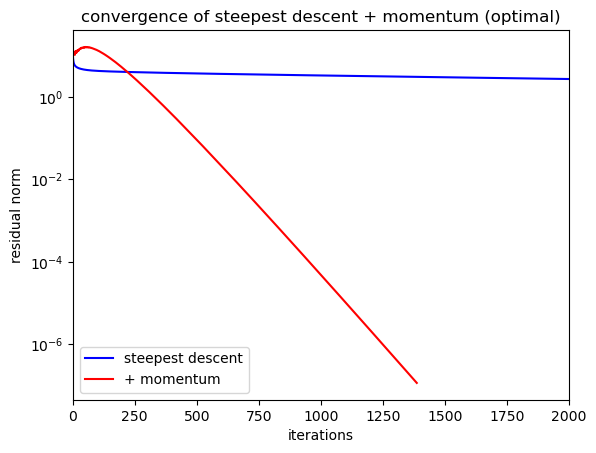

(0.0, 2000.0)

In [29]:
semilogy(rnorm_fixed, "b-")
semilogy(rnorm_asd, "r-")
title("convergence of steepest descent + momentum (optimal)")
ylabel("residual norm")
xlabel("iterations")
legend(["steepest descent", "+ momentum"])
xlim(0, 2000)

In the 2x2 case it is a little harder to see — it actually might be *worse* in the beginning, similar to above, but it quickly accelerates and again gets much closer to the optimum in 20 steps:

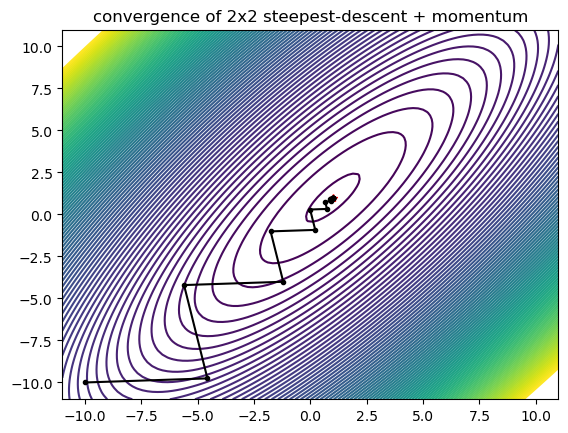

PyObject Text(0.5, 1.0, 'convergence of 2x2 steepest-descent + momentum')

In [30]:
α_opt₂ = (2 / (sqrt(10) + 1))^2
β_opt₂ = ((sqrt(10) - 1) / (sqrt(10) + 1))^2
contour(x1', x1, [dot([x1,x2], A₂*[x1,x2]) - 2*(x1*b₂[1]+x2*b₂[2]) for x1 in x1, x2 in x1], levels=range(1,2000,length=100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:20
    x₂, = ASD(A₂, b₂, [-10.,-10.], maxiters=i, α=α_opt₂, β=β_opt₂)
    push!(x1s, x₂[1])
    push!(x2s, x₂[2])
end
plot(x2s, x1s, "k.-")

title("convergence of 2x2 steepest-descent + momentum")

## Quadratic minimization: Conjugate gradients

A famous way to improve steepest descent with "memory", at least for the *specific* case of *convex quadratic* problems, is the [conjugate-gradient algorithm](https://en.wikipedia.org/wiki/Conjugate_gradient_method).  I won't explain it here ([Shewchuk's article](http://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf) is a good introduction to its relationship to steepest descent), but it turns out to be closely related to the "momentum" method above combined with *exact line search*

In particular, notice the $x_{k} - x_{k-1}$ term in momentum methods can be viewed as being proportional to the **previous step direction** $d_{k-1}$.   So, if we are doing exact line search on every step, we can think of a "momentum" method as choosing a search direction:
$$
d_k = \underbrace{-\nabla f}_{r_k} + \gamma d_{k-1} \, 
$$
a linear combination of the steepest-descent direction $r_k = -\nabla f$ with the previous search direction, for some coefficient $\gamma$.   Amazingly, it is possible to derive an exact formula $\gamma = \| r_k \| / \| r_{k-1} \|$ that is "optimal" in a certain sense, and gives the optimal convergence rate $\sim \sqrt{\kappa}$ from above.

How this is done is outside the scope of 18.C06, but it is beautiful mathematics that leads to the wider theory of "Krylov" iterative methods.

In fact, the conjugate-gradient method for an $m \times m$ matrix $A$ gives the *exact* solution in $m$ steps.  As a practical matter, however, the more important fact is that it gives a good *approximate* solution in many fewer steps.  Let's try it on our examples from above.

In [14]:
function CG(A, b, x=zero(b); tol=1e-8, maxiters=1000)
    bnorm = norm(b)
    r = b - A*x # initial residual
    rnorm = [norm(r)] # return the array of residual norms
    d = copy(r) # initial direction is just steepest-descent
    Ad = zero(r) # allocate space for Ad
    for i = 1:maxiters
        mul!(Ad, A, d) # store matvec A*r in-place in Ar
        α = dot(d, r) / dot(d, Ad)
        x .= x .+ α .* d  # in Julia 0.6, this "fuses" into a single in-place update
        r .= r .- α .* Ad # update the residual (without computing A*x again)
        push!(rnorm, norm(r))
        d .= r .+ d .* (rnorm[end]/rnorm[end-1])^2 # conjugate direction update
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

CG (generic function with 2 methods)

In [15]:
x_cg, rnorm_cg = CG(A, b)
length(rnorm), rnorm[end]/norm(b)

(100001, 2.1898661935779876e-7)

After some initial slow progress, the conjugate-gradient algorithm quickly zooms straight to the solution, vastly faster than steepest descent:

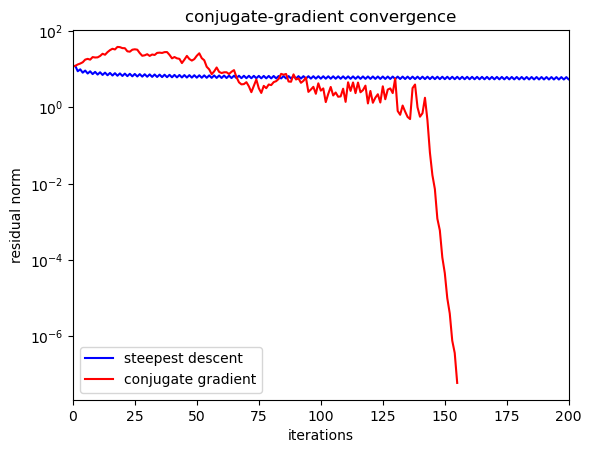

PyObject <matplotlib.legend.Legend object at 0x7fc6b32cae10>

In [16]:
semilogy(rnorm, "b-")
semilogy(rnorm_cg, "r-")
title("conjugate-gradient convergence")
ylabel("residual norm")
xlabel("iterations")
xlim(0, 200)
legend(["steepest descent", "conjugate gradient"])

In our 2x2 problem, you can see that it actually converges in **two steps**:

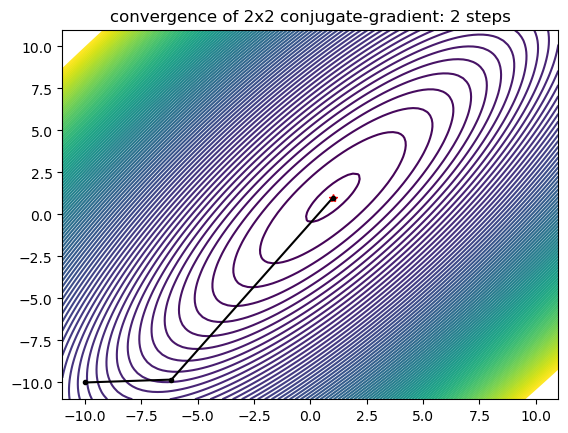

PyObject Text(0.5, 1.0, 'convergence of 2x2 conjugate-gradient: 2 steps')

In [17]:
contour(x1', x1, [dot([x1,x2], A₂*[x1,x2]) - 2*(x1*b₂[1]+x2*b₂[2]) for x1 in x1, x2 in x1], levels=range(1,2000,length=100))
plot(1,1, "r*")
x1s = Float64[]
x2s = Float64[]
for i = 0:2
    x₂, = CG(A₂, b₂, [-10.,-10.], maxiters=i)
    push!(x1s, x₂[1])
    push!(x2s, x₂[2])
end
plot(x2s, x1s, "k.-")

title("convergence of 2x2 conjugate-gradient: 2 steps")

## The Adam algorithm

A popular algorithm for machine learning is [*Adam* (Kingma & Ba, 2015)](https://arxiv.org/pdf/1412.6980.pdf), which is a momentum-like algorithm with some additional twists that make it easier to apply to arbitrary functions (without knowing eigenvalues of the Hessian).

* It has a "momentum" or "memory" term, where the gradient is estimated by a weighted average of the current mini-batch gradient and the previous gradient estimate.
* It also estimates the variance of the gradient components in the same way, and essentially uses this as rough diagonal estimate of the Hessian: it takes a "crude Newton"-like step where the gradient components are weighed inversely by the square roots of their variances.

It's quite simple to implement directly from the description in the paper linked above. Let's try it out on our quadratic optimization problem:

In [81]:
function adam(A, b, x=zero(b); tol=1e-8, maxiters=1000,
                               α = 0.001, ϵ = 1e-8, β₁ = 0.9, β₂ = 0.999) # hyper-parameters from the paper
    bnorm = norm(b)
    var, mom, r = zero(x), zero(x), b - A*x # pre-allocate
    rnorm = Float64[norm(r)] # return the array of residual norms
    for i = 1:maxiters
        # Adam update
        @. mom = β₁*mom - (1-β₁)*r
        @. var = β₂*var + (1-β₂)*r^2
        # m̂ = mom / (1 - β₁^i) # normalize by total weights
        # v̂ = var / (1 - β₂^i) # normalize by total weights
        # x = @. x - α * m̂ / (√v̂ + ϵ)
        @. x -= α * (mom / $(1 - β₁^i)) / (√(var / $(1 - β₂^i)) + ϵ)
        r .= b .- mul!(r, A, x) # b - Ax, in-place
        push!(rnorm, norm(r))
        rnorm[end] ≤ tol*bnorm && break # converged
    end
    return x, rnorm
end

adam (generic function with 2 methods)

In [82]:
x_adam, rnorm_adam = adam(A, b, maxiters=100000)
length(rnorm_adam), rnorm_adam[end]/norm(b)

(100001, 0.004111429305032976)

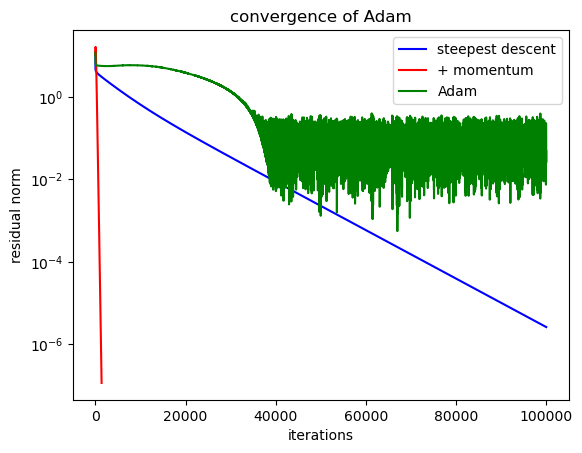

PyObject <matplotlib.legend.Legend object at 0x7fc6af71ad90>

In [83]:
semilogy(rnorm_fixed, "b-")
semilogy(rnorm_asd, "r-")
semilogy(rnorm_adam, "g-")
title("convergence of Adam")
ylabel("residual norm")
xlabel("iterations")
legend(["steepest descent", "+ momentum", "Adam"])
#xlim(0, 2000)

Hmm, either Adam sucks for this problem or I have a bug?